In [ ]:
# !pip install tensorflow==2.11
!git clone https://github.com/modestyachts/cifar-10.2.git

Cloning into 'cifar-10.2'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), 95.54 MiB | 11.21 MiB/s, done.


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import tensorflow as tf
from PIL import Image
from keras.models import Model, Sequential, load_model
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from tensorflow.keras.applications import inception_v3, vgg16, resnet50 

from google.colab import drive
drive.mount('/content/drive')

gdrive_dir = '/content/drive/My Drive/CI/Project/logs/'  # --change to your path--
assert os.path.exists(gdrive_dir)

tf.random.set_seed(420)
tf.__version__

Mounted at /content/drive


'2.9.2'

## Load Dataset

In [ ]:
# Cifar 10.2 
def preprocessCIFAR10_2():
  train_data = np.load('cifar-10.2/cifar102_train.npz')
  test_data = np.load('cifar-10.2/cifar102_test.npz')
  label_names = test_data['label_names']

  x_train = train_data['images']
  y_train = train_data['labels']

  indexes_test = np.array(range(len(x_train)))
  random.shuffle(indexes_test)
  x_train = x_train[indexes_test]
  y_train = y_train[indexes_test]

  x_test = test_data['images']
  y_test = test_data['labels']

  # One-Hot encoding
  y_train = to_categorical(y_train, num_classes=10)
  y_test  = to_categorical(y_test,  num_classes=10)
  return x_train, y_train, x_test, y_test, label_names


# only evaluation
_, _, x_test, y_test, label_names = preprocessCIFAR10_2()
labels = y_test.argmax(axis=1)

## Find Images of Interest

In [ ]:

def grad_cam(model, img, preprocessing, layer_number = -1):
  """
  Grad-CAM implementation based on: 
  https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
  """

  # prepare image and resizing it to the layer size
  img = Image.fromarray(img)
  img = img.resize((299, 299))
  img = tf.keras.preprocessing.image.img_to_array(img)
  grad_model = tf.keras.models.Model(
      inputs=[model.layers[1].inputs], 
      outputs=[model.layers[1].layers[layer_number].output, model.layers[1].output])

  # get loss, predictions and intermediate output at layer
  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(preprocessing(np.array([img])))
      loss = predictions

  # get gradient of the layer (via backpropagation from loss)
  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = gate_f * gate_r * grads

  weights = tf.reduce_mean(guided_grads, axis=(0, 1))

  cam = np.ones(output.shape[0: 2], dtype = np.float32)

  # weighted intermediate results
  for i, w in enumerate(weights):
      cam += w * output[:, :, i]

  # normalize result
  cam = cv2.resize(cam.numpy(), (299, 299))
  cam = np.maximum(cam, 0)
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())



  # Get output image
  cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)

  cv2.imwrite('cam.png', output_image)

  cam = tf.keras.preprocessing.image.load_img('cam.png')
  #print("Layer:", model.layers[1].layers[layer_number].name)
  return cam

In [ ]:
def get_n_highest_idxs(arr: np.ndarray, n):
  ranks = arr.argsort().argsort() + 1
  idxs = np.arange(len(arr))
  return idxs[ranks > len(arr) - n]

def get_n_lowest_idxs(arr: np.ndarray, n):
  ranks = arr.argsort().argsort()
  idxs = np.arange(len(arr))
  return idxs[ranks < n]

In [ ]:
def get_model_results(model, preprocessor):

  x_te = preprocessor(x_test)

  preds = model.predict(x_te)
  losses = categorical_crossentropy(y_test, preds).numpy()
  pred_labels = preds.argmax(axis=1)
  return preds, losses, pred_labels

def get_images_of_interest(losses, n=5):
  
  # index of predictions and images
  worst_all = get_n_highest_idxs(losses, n)
  best_all  = get_n_lowest_idxs(losses, n)

  worst_cat = np.empty((10, n), dtype=int)
  best_cat = np.empty((10, n), dtype=int)
  for i in range(10):

    class_idxs = np.arange(len(labels))[labels == i]
    class_losses = losses[class_idxs]

    # ! indecies change range
    class_worst = get_n_highest_idxs(class_losses, n)
    class_best  = get_n_lowest_idxs(class_losses, n)

    # external indecies
    worst_cat[i] = class_idxs[class_worst]
    best_cat[i]  = class_idxs[class_best]

  return worst_all, best_all, worst_cat, best_cat

In [ ]:
def plot_img_row(n, axs, idxs, pred_labels, model, preprocessing):
  for i in range(n):
    idx = idxs[i]  # or worst_all without cls
    true_cn = label_names[labels[idx]]
    pred_cn = label_names[pred_labels[idx]]
    axs[0,i].imshow(x_test[idx])
    axs[0,i].set_title(f'predicted: {pred_cn}\ntrue: {true_cn}')
    axs[0,i].set_title(f'predicted: {pred_cn}\ntrue: {true_cn}')
    axs[1,i].imshow(grad_cam(model = model, img = x_test[idx], preprocessing=preprocessing, layer_number = -1))
    axs[1,i].set_title(f'visualisation: {true_cn}')



def plot_images_of_interest(pred_labels, ioi_results, model, preprocessing):

  worst_all, best_all, worst_cat, best_cat = ioi_results
  n = len(worst_all)

  print(f'\nplotting worst {n} overall classes:\n')
  fig, axs = plt.subplots(2, n, figsize=(8,8))
  for ax in axs.flat: ax.axis('off') 
  plot_img_row(n, axs, worst_all, pred_labels, model, preprocessing)
  plt.show()

  print(f'\nplotting best {n} overall classes:\n')
  fig, axs = plt.subplots(2, n, figsize=(8,8))
  for ax in axs.flat: ax.axis('off')
  plot_img_row(n, axs, best_all, pred_labels, model, preprocessing)
  plt.show()

  print(f'\nplotting worst {n} for each class:\n')
  fig, axs = plt.subplots(20, n, figsize=(8,80))
  for ax in axs.flat: ax.axis('off') 
  for cls in range(10): 
    plot_img_row(n, axs[cls*2:cls*2+2], worst_cat[cls], pred_labels, model, preprocessing)
  plt.show()

  print(f'\nplotting best {n} for each class:\n')
  fig, axs = plt.subplots(20, n, figsize=(8,80))
  for ax in axs.flat: ax.axis('off') 
  for cls in range(10): 
    plot_img_row(n, axs[cls*2:cls*2+2], best_cat[cls], pred_labels, model, preprocessing)
  plt.show()

In [ ]:
# uncomment the model the grad cam analysis should be appllied on

# resnet50
#model = load_model(gdrive_dir + 'final_resNet50.h5') 
#preproc = resnet50.preprocess_input

# vgg16
#model = load_model(gdrive_dir + 'final_vgg16.h5')
#preproc = vgg16.preprocess_input

# inceptionv3
model = load_model(gdrive_dir + 'final_inceptionv3.h5')
preproc = inception_v3.preprocess_input

63/63 [==============================] - 11s 128ms/step



plotting worst 2 overall classes:



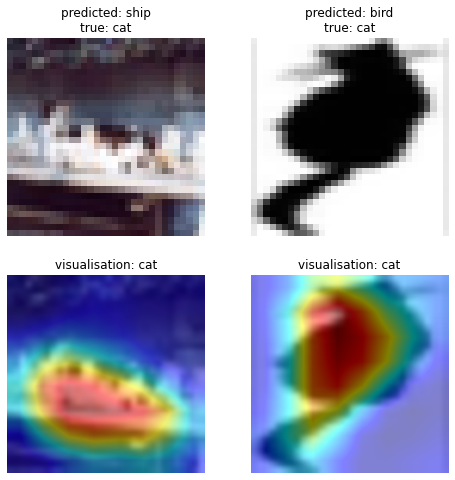


plotting best 2 overall classes:



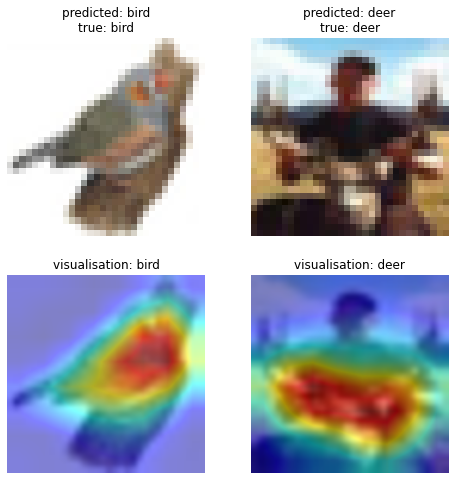


plotting worst 2 for each class:



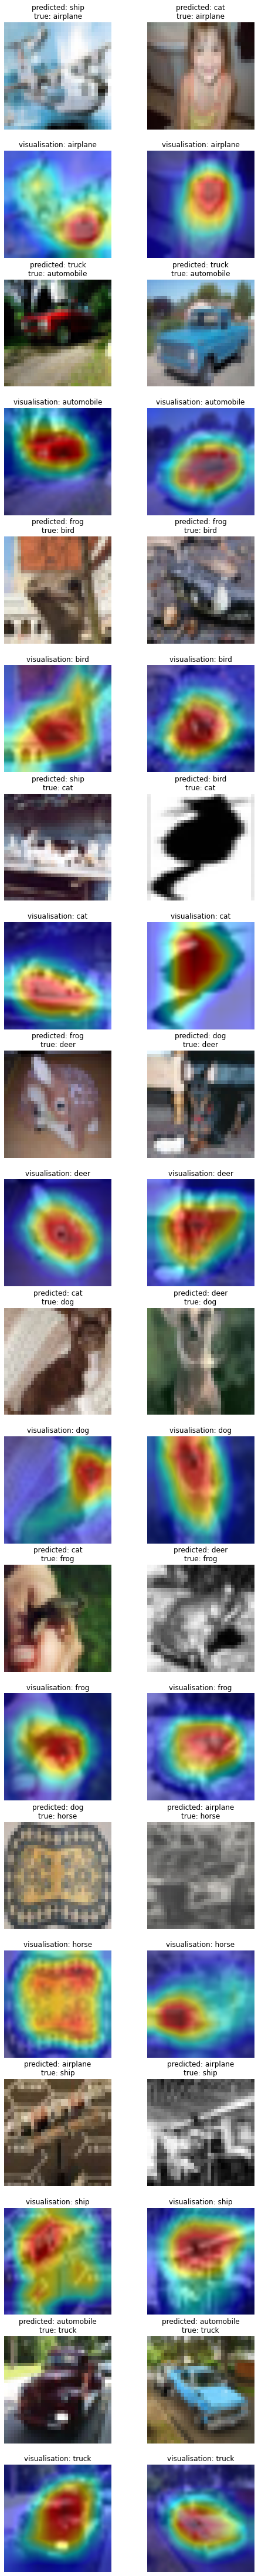


plotting best 2 for each class:



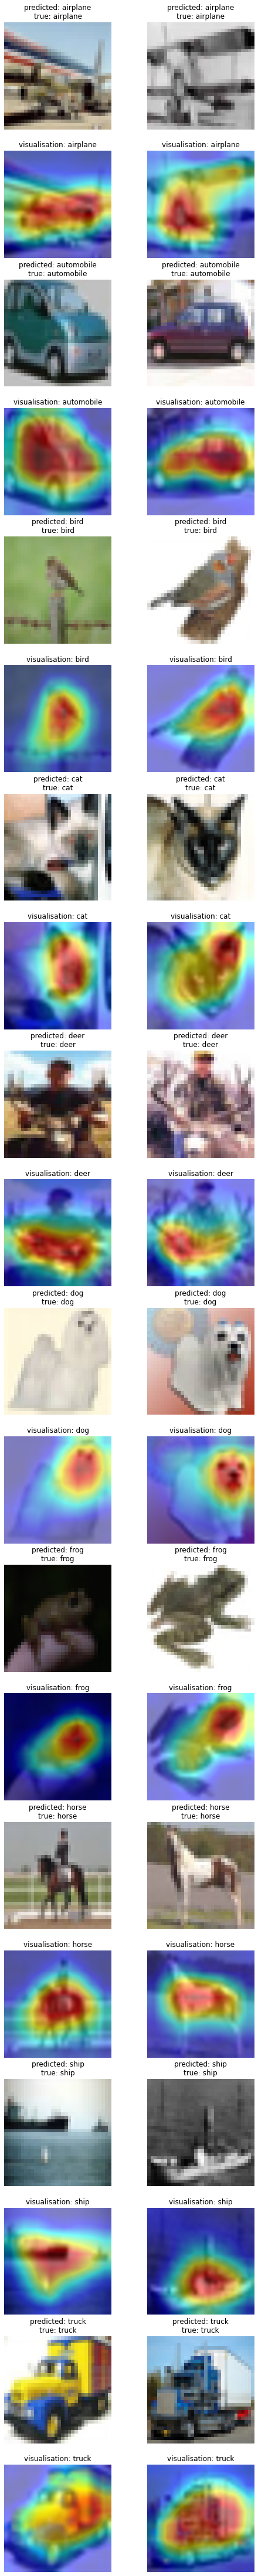

In [ ]:
_, losses, pred_labels = get_model_results(model, preproc)
ioi_results = get_images_of_interest(losses, n=2)

plot_images_of_interest(pred_labels, ioi_results, model, preproc)